<a href="https://colab.research.google.com/github/ArifAygun/Iron-Ore-Froth-Flotation-Quality-Prediction/blob/main/AA_Iron_Ore_Froth_Flotation_Quality_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Quality Prediction of Iron Ore Mining Flotation Process**

##**1. Problem Definition**

**Gangue concentrate predict in the reverse cationic flotation:**


Mined ores are mostly mixtures of extractable minerals and nonvaluable material (gangue). Mineral processing (e.g. ore dressing, ore beneficiation) follows mining and prepares the ore for extraction of the valuable metal. A principal step in mineral processing is physical separation of the particles of valuable minerals from the gangue, to produce an enriched portion (concentrate) containing most of the valuable minerals, and a discard (tailing) containing predominantly the gangue.

A separation of minerals by exploiting difference of surface properties (hydrophobicity) is called flotation. **The reverse cationic flotation** is commonly used to separate iron from silica. By adjusting the 'chemistry' of the pulp by adding various chemical reagents, iron minerals remain in the water and create sediment with a high concentration of iron (valuable minerals). At the same time, silica particles (gangue) attach to air bubbles and float to the surface.

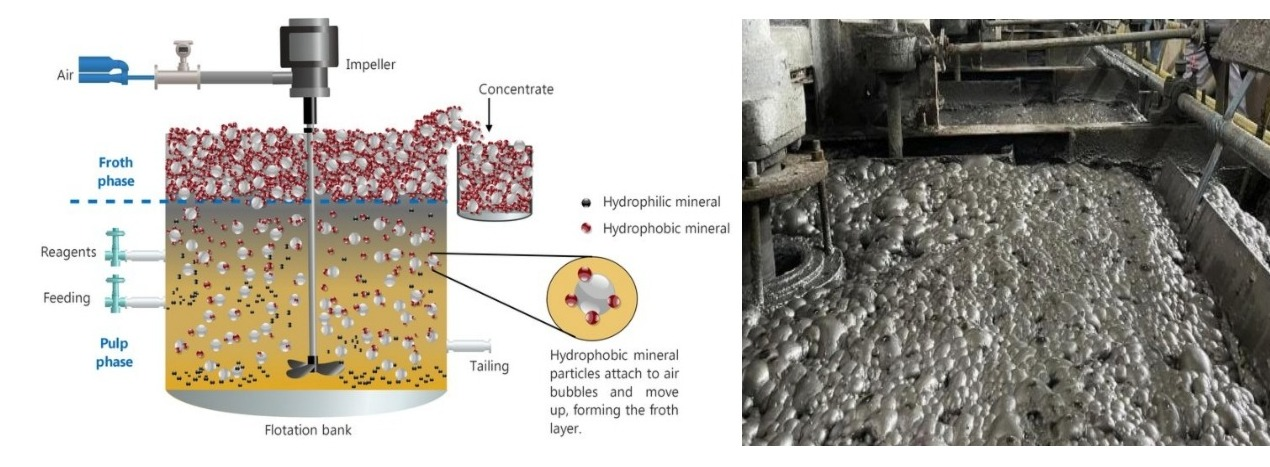

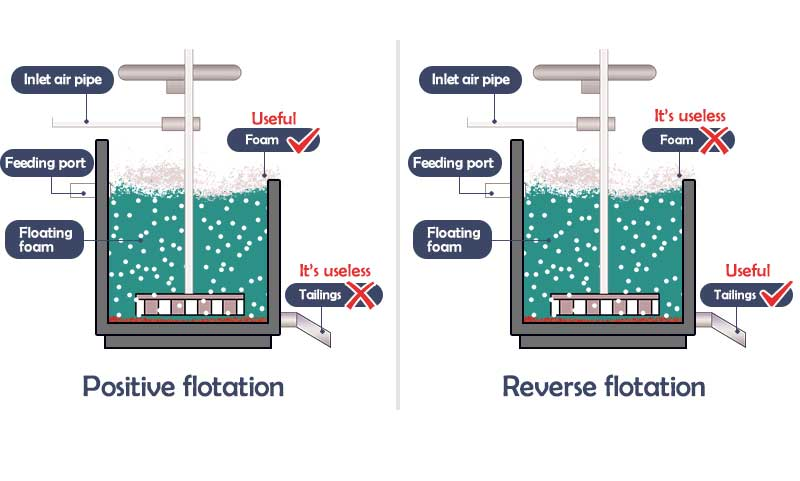

Flotation concentrate is periodically sampled to determine its purity (i.e., *%valuable*, *%gangue*). Higher *%gangue* in the concentrate is undesirable as it indicates that most valuable minerals had gone into the tailing. Purity measurement is usually done in a lab and can take some time before process engineers can make any adjustments based on the results. A timely investigation of concentrate purity is, therefore, a fundamental aspect for the control and optimization of the flotation process.

This project explores the application of machine learning to predict gangue (*%silica*) in the flotation concentrate. The prediction will help process engineers assess purity of flotation concentrate and take corrective actions in advance. More specifically, the goal is to tackle the following task:
- **To predict the last column (dependent variable), which is the % of silica in the iron ore concentrate.**

##**2. Data Understanding**

###**2.1. Data Definitions**

- **Date**: Data collection time.
- **% Iron Feed**: Feed grade of iron-containing ore.
- **% Silica Feed**: Feed grade of silica-containing ore.
- **Starch Flow**: Depressant chemical for Iron(Fe) containing ore measured in m³/h.
- **Amina Flow**: Collector chemical for Silica containing ore measured in m³/h.
- **Ore Pulp Flow**: The amount of pulp flow fed to the flotation columns as the product of the previous process step measured in t/h.
- **Ore Pulp pH**: pH is measured in pH scale.
- **Ore Pulp Density**: The solid percent of ore fed density ranges in kg/cm³
- **Flotation Column 01, 02, 03, 04, 05, 06, 07 Air Flow**: Air Flows that goes into the flotation cell measured in Nm³/h.
- **Flotation Column 01, 02, 03, 04, 05, 06, 07 Level**: Froth level in the flotation cell measured in mm.
- **% Iron Concentrate**: Concentrate grade of iron-containing ore in percentage.
- **% Silica Concentrate**: Concentrate grade of silica-containing ore in percentage

###**2.2. Inspection of the data**

- The first column shows time and date range (march 2017 -  september 2017). 
- Some columns were sampled every 20 second. Others were sampled on a hourly base.
- The second and third columns are quality measures of the iron ore pulp right before it is fed into the flotation plant. 
- From Column 4 until column 8 are the most important variables that impact in the ore quality in the end of the process. 
- From column 9 until column 22, we can see process data (froth level and air flow inside the flotation columns, which also impact in ore quality). 
- The last two columns are the final iron ore pulp quality measurement from the lab. 

##**3. Data Collection**

###**3.1. Import libraries modules and dataset**

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, boxcox
import os
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler

In [37]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive/Flotation/

flotation = pd.read_csv('Flotation_Plant.csv', decimal = ",")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Flotation


###**3.2. Reduce memory usage**

In [38]:
# Use a function to reduce memory usage of the dataframe by modifying the datatypes
def reduce_mem_usage(flotation, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = flotation.memory_usage().sum() / 1024**2    
    for col in flotation.columns:
        col_type = flotation[col].dtypes
        if col_type in numerics:
            c_min = flotation[col].min()
            c_max = flotation[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    flotation[col] = flotation[col].astype(np.int8)
                elif c_min > flotation.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       flotation[col] = flotation[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    flotation[col] = flotation[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    flotation[col] = flotation[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    flotation[col] = flotation[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    flotation[col] = flotation[col].astype(np.float32)
                else:
                    flotation[col] = flotation[col].astype(np.float64)    
    end_mem = flotation.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return flotation

In [14]:
flotation = reduce_mem_usage(flotation)

Mem. usage decreased to 70.33 Mb (47.9% reduction)


- Memory usage decrased from 135.0+ MB to 70.33 MB

##**4. Data Preprocessing**

###**4.1. Dataset information**

In [4]:
flotation.head().T

,0,1,2,3,4
date,2017-03-10 01:00:00,2017-03-10 01:00:00,2017-03-10 01:00:00,2017-03-10 01:00:00,2017-03-10 01:00:00
% Iron Feed,55.2,55.2,55.2,55.2,55.2
% Silica Feed,16.98,16.98,16.98,16.98,16.98
Starch Flow,3019.53,3024.41,3043.46,3047.36,3033.69
Amina Flow,557.434,563.965,568.054,568.665,558.167
Ore Pulp Flow,395.713,397.383,399.668,397.939,400.254
Ore Pulp pH,10.0664,10.0672,10.068,10.0689,10.0697
Ore Pulp Density,1.74,1.74,1.74,1.74,1.74
Flotation Column 01 Air Flow,249.214,249.719,249.741,249.917,250.203
Flotation Column 02 Air Flow,253.235,250.532,247.874,254.487,252.136


In [6]:
flotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   date                          737453 non-null  object 
 1   % Iron Feed                   737453 non-null  float64
 2   % Silica Feed                 737453 non-null  float64
 3   Starch Flow                   737453 non-null  float64
 4   Amina Flow                    737453 non-null  float64
 5   Ore Pulp Flow                 737453 non-null  float64
 6   Ore Pulp pH                   737453 non-null  float64
 7   Ore Pulp Density              737453 non-null  float64
 8   Flotation Column 01 Air Flow  737453 non-null  float64
 9   Flotation Column 02 Air Flow  737453 non-null  float64
 10  Flotation Column 03 Air Flow  737453 non-null  float64
 11  Flotation Column 04 Air Flow  737453 non-null  float64
 12  Flotation Column 05 Air Flow  737453 non-nul

- 7 Flotation Column Air Flow columns have similar values, transform to 1 column
- 7 Flotation Column Level columns have similar values, transform to 1 column
- For further analysis "date" column will not be used,
- Therefore we will drop unnecessary columns. 

In [39]:
flotation['Flotation Column Air Flow'] = flotation[['Flotation Column 01 Air Flow', 
                                                  'Flotation Column 02 Air Flow',
                                                  'Flotation Column 03 Air Flow',
                                                  'Flotation Column 04 Air Flow',
                                                  'Flotation Column 05 Air Flow',
                                                  'Flotation Column 06 Air Flow',
                                                  'Flotation Column 07 Air Flow']].mean(axis=1)

flotation['Flotation Column Air Level'] = flotation[['Flotation Column 01 Level',
                                                   'Flotation Column 02 Level',
                                                   'Flotation Column 03 Level',
                                                   'Flotation Column 04 Level',
                                                   'Flotation Column 05 Level',
                                                   'Flotation Column 06 Level',
                                                   'Flotation Column 07 Level']].mean(axis=1)

flotation.drop(['Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
                'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
                'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
                'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
                'Flotation Column 02 Level', 'Flotation Column 03 Level',
                'Flotation Column 04 Level', 'Flotation Column 05 Level',
                'Flotation Column 06 Level', 'Flotation Column 07 Level'], axis=1, inplace=True)

flotation.drop('date', axis=1, inplace=True)

column_order = ['% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow', 'Ore Pulp Flow',
                'Ore Pulp pH', 'Ore Pulp Density', 'Flotation Column Air Flow',
                'Flotation Column Air Level', '% Iron Concentrate', '% Silica Concentrate']

flotation = flotation.reindex(columns=column_order)

flotation.head().T

,0,1,2,3,4
% Iron Feed,55.200000,55.200000,55.200,55.200000,55.200000
% Silica Feed,16.980000,16.980000,16.980,16.980000,16.980000
Starch Flow,3019.530000,3024.410000,3043.460,3047.360000,3033.690000
Amina Flow,557.434000,563.965000,568.054,568.665000,558.167000
Ore Pulp Flow,395.713000,397.383000,399.668,397.939000,400.254000
Ore Pulp pH,10.066400,10.067200,10.068,10.068900,10.069700
Ore Pulp Density,1.740000,1.740000,1.740,1.740000,1.740000
Flotation Column Air Flow,265.090000,264.534286,264.120,265.359714,264.663000
Flotation Column Air Level,461.548429,457.548000,456.467,448.064429,448.784714
% Iron Concentrate,66.910000,66.910000,66.910,66.910000,66.910000


In [29]:
flotation.shape

(737453, 11)

###**4.2. Rename the columns**

In [40]:
# Rename column names
old_columns = ['% Iron Feed', '% Silica Feed', 'Starch Flow','Amina Flow', 
               'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density',
               'Flotation Column Air Flow', 'Flotation Column Air Level', 
               '% Iron Concentrate', '% Silica Concentrate']

new_columns = ["iron_feed", "silica_feed", "starch_flow", "amina_flow", 
               "pulp_flow", "pulp_pH", "pulp_density", "airflow_col", 
               "level_col", "iron_conc", "silica_conc"]

flotation = flotation.rename(columns=dict(zip(old_columns, new_columns)))
flotation.columns

Index(['iron_feed', 'silica_feed', 'starch_flow', 'amina_flow', 'pulp_flow',
       'pulp_pH', 'pulp_density', 'airflow_col', 'level_col', 'iron_conc',
       'silica_conc'],
      dtype='object')

###**4.3. Check Missing & Duplicated Values**

In [41]:
missing_values = flotation.isnull().sum()
print(missing_values)

iron_feed       0
silica_feed     0
starch_flow     0
amina_flow      0
pulp_flow       0
pulp_pH         0
pulp_density    0
airflow_col     0
level_col       0
iron_conc       0
silica_conc     0
dtype: int64


- No missing values across the dataframe

In [42]:
#check duplicated rows
duplicate_rows = flotation[flotation.duplicated()]
duplicate_rows.shape

(1171, 11)

- There are 1171 duplicated values

In [43]:
#drop duplicated rows
flotation = flotation.drop_duplicates()

- Now dataset has 736282 data points.

In [44]:
flotation.shape

(736282, 11)

###**4.4. Dataset summary statistics**

In [45]:
flotation.describe().T

,count,mean,std,min,25%,50%,75%,max
iron_feed,736282.0,56.298307,5.160365,42.740000,52.670000,56.080000,59.720000,65.780000
silica_feed,736282.0,14.648984,6.810741,1.310000,8.940000,13.850000,19.600000,33.400000
starch_flow,736282.0,2869.636615,1216.017896,0.002026,2075.070000,3020.230000,3728.930000,6300.230000
amina_flow,736282.0,488.165523,91.254428,241.669000,431.835848,504.352500,553.335750,739.538000
pulp_flow,736282.0,397.570736,9.705444,376.249000,394.248000,399.238000,402.967000,418.641000
pulp_pH,736282.0,9.767315,0.387176,8.753340,9.527050,9.797460,10.037800,10.808100
pulp_density,736282.0,1.680424,0.069206,1.519820,1.647390,1.697580,1.728380,1.853250
airflow_col,736282.0,288.637269,18.708912,218.458979,277.783750,298.655429,300.461857,330.498688
level_col,736282.0,467.153076,78.383498,255.408810,399.512429,455.928643,517.532070,746.034662
iron_conc,736282.0,65.049096,1.118721,62.050000,64.370000,65.210000,65.860000,68.010000



- **iron_feed**: Percentage of iron in the slurry being fed to the flotation cells (0-100%). (Min 42.74%, max 65.78%)
- **silica_feed**: Percentage of silica in the slurry being fed to the flotation cells. (0-100%). (Min 1.31%, max 33.4%)
- **starch_flow**: Flow rate of starch (reactive) measured in m3/h. (min 0.002026 m3/h, max 6300.23 m3/h)
- **amina_flow**: Flow rate of amine (reactive) measured in m3/h. (min 241.669 m3/h, max 739.538 m3/h)
- **pulp_flow**: Feed flow rate of pulp measured in t/h. (min 376.249 t/h, max 418.641 m3/h)
- **pulp_pH**: pH of the pulp, scale from 0 to 14. (min 8.7533 ph, max 10.808ph)
- **pulp_density**: Density of the pulp measured in kg/cm³. (min 1.519 kg/cm3, max 1.853 kg/cm3)
- **airflow_col**: Air flow rate entering flotation cell 1, measured in Nm³/h. (min 218.459 Nm3/h, max 330.499 Nm3/h)
- **level_col**: Height of the bubble layer at the top of flotation cell 1, measured in mm. (min 255.409 mm, max 746.035 mm)

**```Target Variable```**
- **silica_conc**: Percentage of silica in the concentrate at the end of the flotation process, (min 0.6%, max 5.63%) 

- Dataset variables have very wide range data point values.


###**4.5. Dataset normalisation**

- Normalizing the dataset is necessary to bring the features or variables to a similar scale or range.

In [47]:
from sklearn.preprocessing import MinMaxScaler

# Select the columns to normalize
columns_to_normalize = ["iron_feed", "silica_feed", "starch_flow", "amina_flow", 
                        "pulp_flow", "pulp_pH", "pulp_density", "airflow_col", 
                        "level_col", "iron_conc", "silica_conc"]

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Apply Min-Max scaling to the selected columns
flotation[columns_to_normalize] = scaler.fit_transform(flotation[columns_to_normalize])


In [48]:
flotation.head()

,iron_feed,silica_feed,starch_flow,amina_flow,pulp_flow,pulp_pH,pulp_density,airflow_col,level_col,iron_conc,silica_conc
0,0.540799,0.488314,0.479273,0.634233,0.459143,0.639033,0.660348,0.416201,0.420156,0.815436,0.144016
1,0.540799,0.488314,0.480047,0.647351,0.498537,0.639423,0.660348,0.411241,0.412003,0.815436,0.144016
2,0.540799,0.488314,0.483071,0.655564,0.552439,0.639812,0.660348,0.407543,0.409799,0.815436,0.144016
3,0.540799,0.488314,0.483690,0.656791,0.511653,0.640250,0.660348,0.418608,0.392673,0.815436,0.144016
4,0.540799,0.488314,0.481520,0.635705,0.566263,0.640639,0.660348,0.412390,0.394141,0.815436,0.144016


In [96]:
# describe dataset after normalisation
flotation.describe().T

,count,mean,std,min,25%,50%,75%,max
silica_feed,736282.0,0.415674,0.212239,0.0,0.237769,0.390776,0.569959,1.0
starch_flow,736282.0,0.455481,0.193012,0.0,0.329364,0.479384,0.591872,1.0
amina_flow,736282.0,0.495103,0.183290,0.0,0.381962,0.527616,0.626002,1.0
pulp_flow,736282.0,0.502966,0.228945,0.0,0.424585,0.542296,0.630260,1.0
pulp_pH,736282.0,0.493476,0.188429,0.0,0.376545,0.508147,0.625114,1.0
pulp_density,736282.0,0.481672,0.207557,0.0,0.382599,0.533125,0.625499,1.0
airflow_col,736282.0,0.626370,0.166985,0.0,0.529498,0.715786,0.731909,1.0
level_col,736282.0,0.431580,0.159762,0.0,0.293714,0.408702,0.534263,1.0
silica_conc,736282.0,0.350359,0.228320,0.0,0.170385,0.283976,0.488844,1.0


###**4.7. Corellation between the variables**

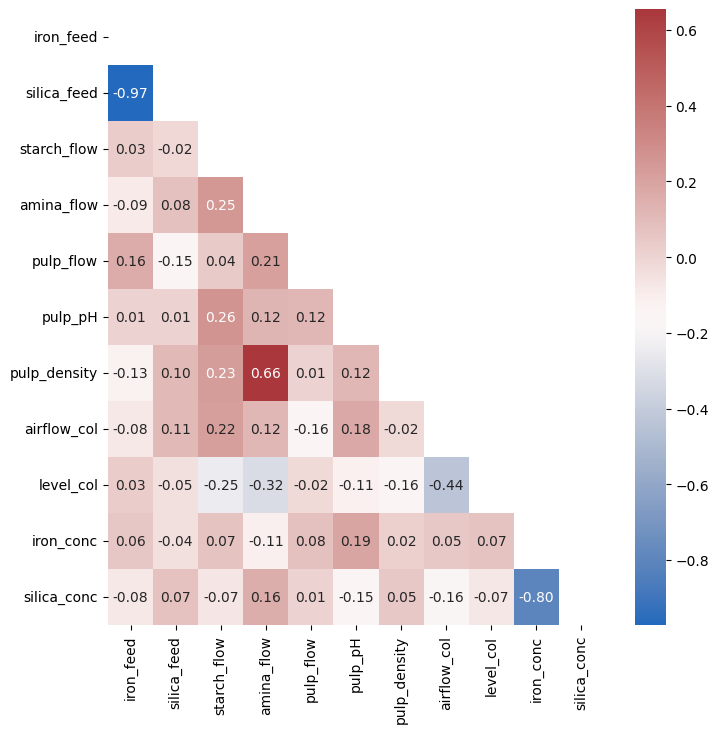

In [55]:
mask = np.triu(np.ones_like(flotation.corr(), dtype=bool))
plt.figure(figsize=(8, 8))
sns.heatmap(flotation.corr(), annot=True, fmt='.2f', cmap='vlag', 
            annot_kws={"fontsize": 10}, mask=mask)
plt.show()


In [56]:
sorted_corr = flotation.corr().unstack().abs().sort_values(ascending=False)
sorted_corr = sorted_corr[(sorted_corr > 0.60) & (sorted_corr < 1)]
sorted_corr.head(20)

iron_feed     silica_feed     0.971876
silica_feed   iron_feed       0.971876
silica_conc   iron_conc       0.800598
iron_conc     silica_conc     0.800598
amina_flow    pulp_density    0.655352
pulp_density  amina_flow      0.655352
dtype: float64

- ```iron_feed```  variable is highly correlated with ```silica_feed```
- ```silica_conc```  variable is highly correlated with ```iron_conc``` 

We will drop ```iron_feed```, ```iron_conc```

In [57]:
flotation.drop(['iron_feed', 'iron_conc'], axis=1, inplace=True)

In [58]:
flotation.shape

(736282, 9)

###**4.8. Check Outliers**

- Visualize the variables for seeing outliers

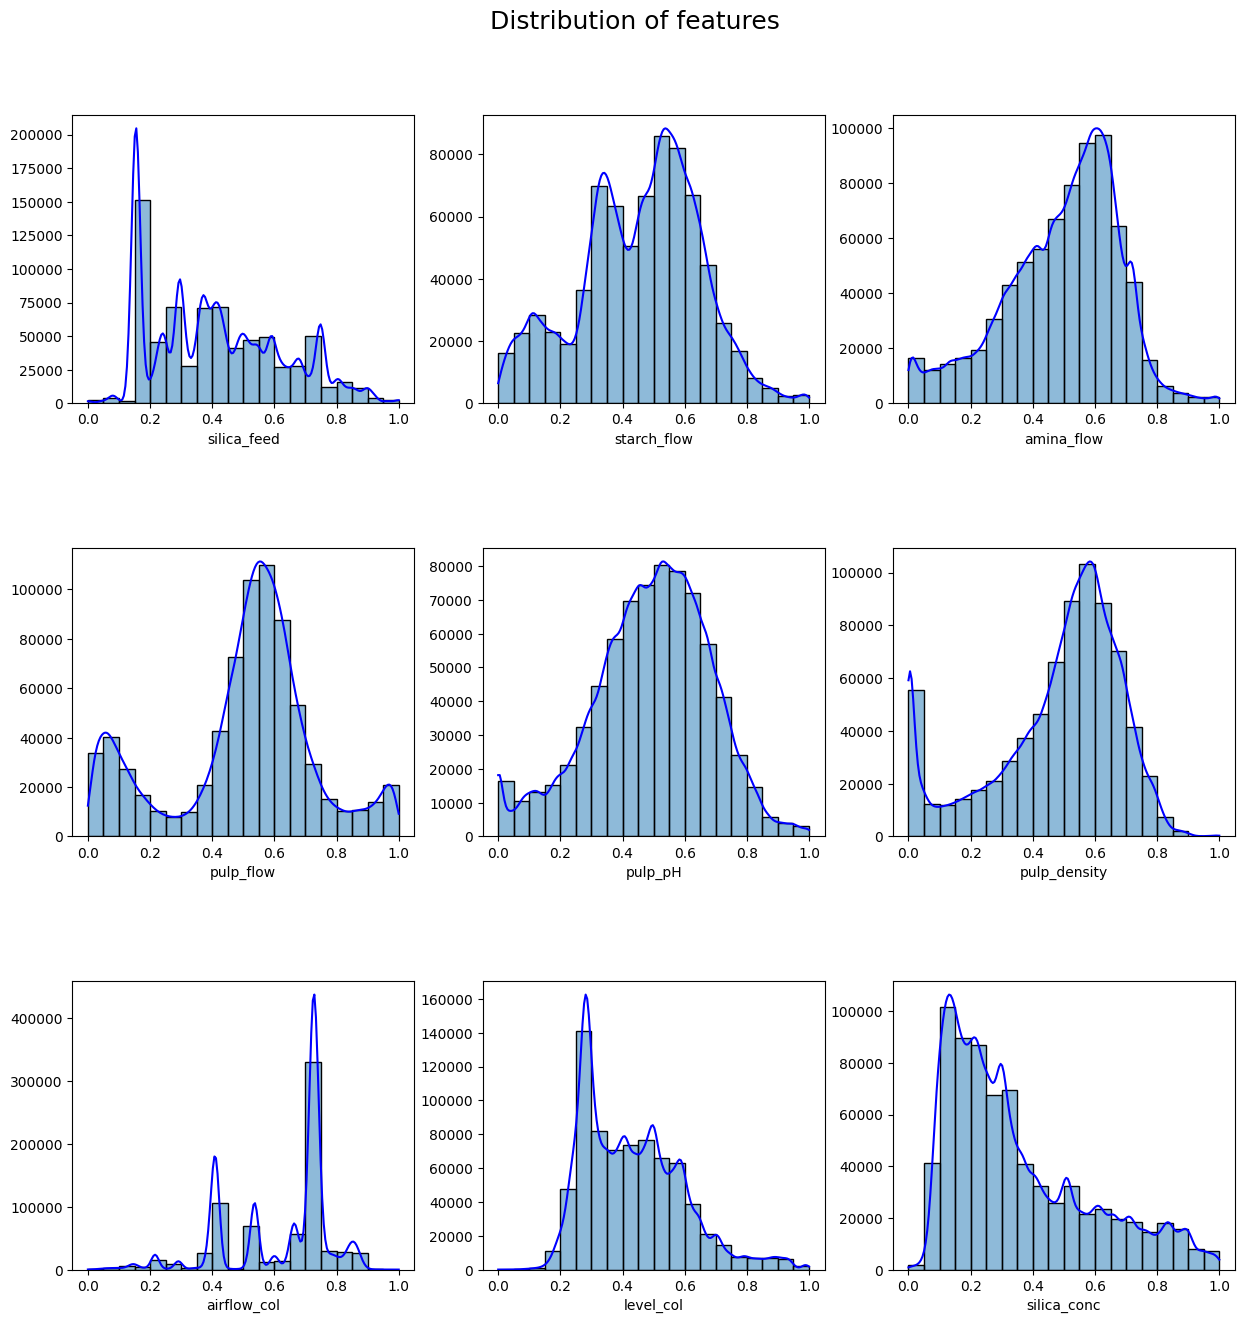

In [97]:
# histogram of the features
features = flotation.columns
plt.figure(figsize= (15,15))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Distribution of features", fontsize=18, y=0.95)
for i, feature in enumerate(features):
 k = i + 1
 plt.subplot(3,3,int(k))
 sns.histplot(data=flotation, x=feature, kde=True, bins = 20).lines[0].set_color('blue')
 plt.xlabel(feature)
 plt.ylabel("")
plt.show()

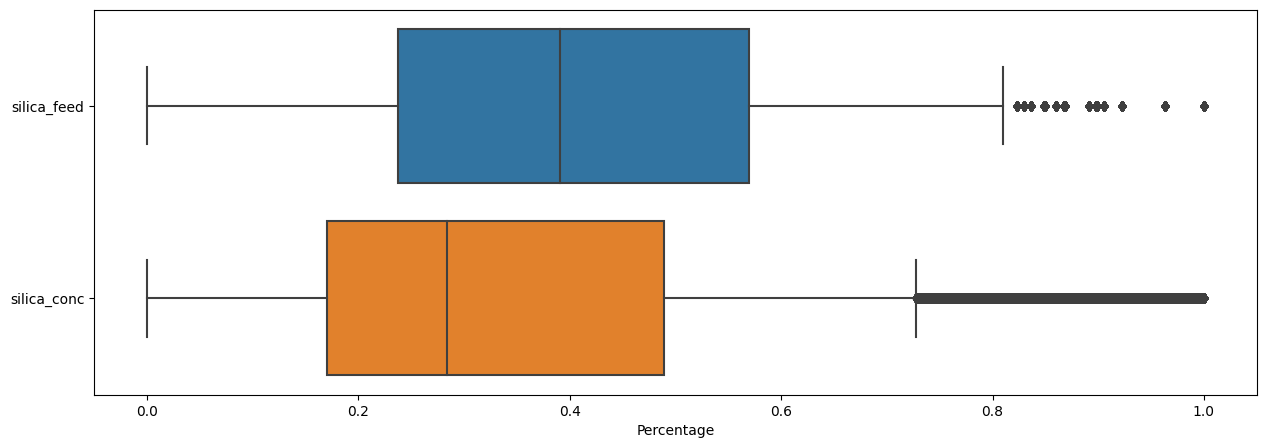

In [100]:
#box plots of input and output values with whisker is 0.75
plt.figure(figsize = (15, 5))
sns.boxplot(data = flotation[["silica_feed", "silica_conc"]], whis=0.75, orient = 'h')
plt.xlabel('Percentage');

In [64]:
from scipy.stats import zscore

zscores = zscore(flotation["silica_conc"])
for i in range(1,5):
    print("The score threshold is: {}".format(i))
    print("The indices of the outliers:")
    print(np.where(zscores > i))
    print("Number of outliers is: {}".format(len((np.where(zscores > i)[0]))))
    print('--'*40)

The score threshold is: 1
The indices of the outliers:
(array([  3054,   3055,   3056, ..., 732139, 732140, 732141]),)
Number of outliers is: 134214
--------------------------------------------------------------------------------
The score threshold is: 2
The indices of the outliers:
(array([  5214,   5215,   5216, ..., 715457, 715458, 715459]),)
Number of outliers is: 46775
--------------------------------------------------------------------------------
The score threshold is: 3
The indices of the outliers:
(array([], dtype=int64),)
Number of outliers is: 0
--------------------------------------------------------------------------------
The score threshold is: 4
The indices of the outliers:
(array([], dtype=int64),)
Number of outliers is: 0
--------------------------------------------------------------------------------


In [66]:
zscores = zscore(flotation["silica_conc"])
for i in range(1,5):
    print("The score threshold is: {}".format(i))
    print("The indices of the outliers:")
    print(np.where(zscores > i))
    print("Number of outliers is: {}".format(len((np.where(zscores > i)[0]))))
    print('--'*40)

The score threshold is: 1
The indices of the outliers:
(array([  3054,   3055,   3056, ..., 732139, 732140, 732141]),)
Number of outliers is: 134214
--------------------------------------------------------------------------------
The score threshold is: 2
The indices of the outliers:
(array([  5214,   5215,   5216, ..., 715457, 715458, 715459]),)
Number of outliers is: 46775
--------------------------------------------------------------------------------
The score threshold is: 3
The indices of the outliers:
(array([], dtype=int64),)
Number of outliers is: 0
--------------------------------------------------------------------------------
The score threshold is: 4
The indices of the outliers:
(array([], dtype=int64),)
Number of outliers is: 0
--------------------------------------------------------------------------------


In [67]:
zscores = zscore(flotation["silica_conc"].dropna())
for i in range(1,5):
    print("The score threshold is: {}".format(i))
    print("The indices of the outliers:")
    print(np.where(zscores > i))
    print("Number of outliers is: {}".format(len((np.where(zscores > i)[0]))))
    print('--'*40)

The score threshold is: 1
The indices of the outliers:
(array([  3054,   3055,   3056, ..., 732139, 732140, 732141]),)
Number of outliers is: 134214
--------------------------------------------------------------------------------
The score threshold is: 2
The indices of the outliers:
(array([  5214,   5215,   5216, ..., 715457, 715458, 715459]),)
Number of outliers is: 46775
--------------------------------------------------------------------------------
The score threshold is: 3
The indices of the outliers:
(array([], dtype=int64),)
Number of outliers is: 0
--------------------------------------------------------------------------------
The score threshold is: 4
The indices of the outliers:
(array([], dtype=int64),)
Number of outliers is: 0
--------------------------------------------------------------------------------


 # Tukey Method

In [68]:
q75, q25 = np.percentile(flotation['silica_conc'].dropna(),[75 ,25])
IQR = q75 - q25
threshold_values=[]
for threshold_value in np.arange(1,5,0.5):
    min_value = q25 - (IQR*threshold_value)
    max_value = q75 + (IQR*threshold_value)
    outlier_value_number = len((np.where((flotation['silica_conc'].dropna() > max_value)| (flotation['silica_conc'].dropna() < min_value))[0]))
    threshold_values.append({'threshold_value': threshold_value,'outlier_value_number': outlier_value_number})

In [69]:
pd.DataFrame(threshold_values)

,threshold_value,outlier_value_number
0,1.0,46544
1,1.5,4757
2,2.0,0
3,2.5,0
4,3.0,0
5,3.5,0
6,4.0,0
7,4.5,0


In [70]:
import numpy as np

# Calculate quartiles and IQR
q75, q25 = np.percentile(flotation['silica_conc'].dropna(), [75, 25])
IQR = q75 - q25

# Define the threshold value
threshold_value = 1

# Calculate the minimum and maximum values for the threshold
min_value = q25 - (IQR * threshold_value)
max_value = q75 + (IQR * threshold_value)

# Identify outliers using the threshold
outliers = flotation[(flotation['silica_conc'] > max_value) | (flotation['silica_conc'] < min_value)]['silica_conc']

# Print the number of outliers
print(f"Number of outliers with threshold {threshold_value}: {len(outliers)}")


Number of outliers with threshold 1: 46544


In [71]:
import numpy as np

# Calculate quartiles and IQR
q75, q25 = np.percentile(flotation['silica_conc'].dropna(), [75, 25])
IQR = q75 - q25

# Define the threshold value
threshold_value = 1

# Calculate the minimum and maximum values for the threshold
min_value = q25 - (IQR * threshold_value)
max_value = q75 + (IQR * threshold_value)

# Filter the DataFrame to exclude outliers
filtered_data = flotation[(flotation['silica_conc'] >= min_value) & (flotation['silica_conc'] <= max_value)]

# Print the number of eliminated outliers
num_outliers = len(flotation) - len(filtered_data)
print(f"Number of eliminated outliers with threshold {threshold_value}: {num_outliers}")


Number of eliminated outliers with threshold 1: 46544


In [72]:
flotation.shape


(736282, 9)

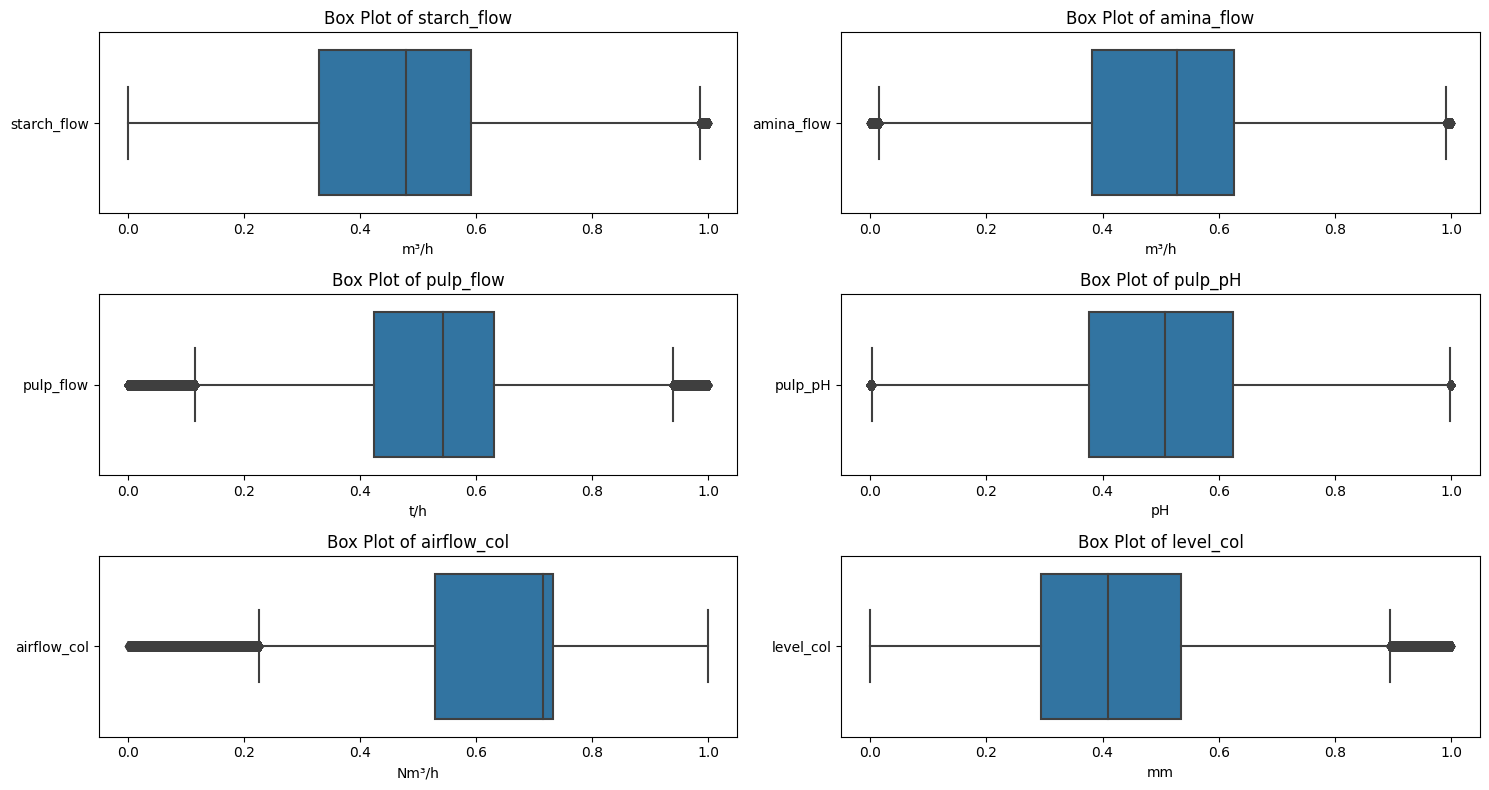

In [95]:
fig, axes = plt.subplots(3, 2, figsize=(15, 8))

# Box plots for starch_flow
sns.boxplot(data=flotation[["starch_flow"]], orient='h', ax=axes[0, 0])
axes[0, 0].set_xlabel('m³/h')
axes[0, 0].set_title('Box Plot of starch_flow')

# Box plots for amina_flow
sns.boxplot(data=flotation[["amina_flow"]], orient='h', ax=axes[0, 1])
axes[0, 1].set_xlabel('m³/h')
axes[0, 1].set_title('Box Plot of amina_flow')

# Box plots for pulp_flow
sns.boxplot(data=flotation[["pulp_flow"]], orient='h', ax=axes[1, 0])
axes[1, 0].set_xlabel('t/h')
axes[1, 0].set_title('Box Plot of pulp_flow')

# Box plots for pulp_pH
sns.boxplot(data=flotation[["pulp_pH"]], orient='h', ax=axes[1, 1])
axes[1, 1].set_xlabel('pH')
axes[1, 1].set_title('Box Plot of pulp_pH')

# Box plots for airflow_col
sns.boxplot(data=flotation[["airflow_col"]], orient='h', ax=axes[2, 0])
axes[2, 0].set_xlabel('Nm³/h')
axes[2, 0].set_title('Box Plot of airflow_col')

# Box plots for level_col
sns.boxplot(data=flotation[["level_col"]], orient='h', ax=axes[2, 1])
axes[2, 1].set_xlabel('mm')
axes[2, 1].set_title('Box Plot of level_col')

plt.tight_layout()
plt.show()


In [80]:
flotation.columns


Index(['silica_feed', 'starch_flow', 'amina_flow', 'pulp_flow', 'pulp_pH',
       'pulp_density', 'airflow_col', 'level_col', 'silica_conc'],
      dtype='object')

In [101]:
import pandas as pd
import numpy as np

# Specify the columns to consider for outlier removal
columns_to_check = ["silica_feed", "starch_flow","amina_flow", 
                    "pulp_flow", "pulp_pH", "pulp_density",
                    "airflow_col", "level_col","silica_conc"]

# Loop over each column to identify and eliminate outliers
for column in columns_to_check:
    # Calculate the lower and upper thresholds
    lower_threshold = np.percentile(flotation[column], 25) - 1.5 * (np.percentile(flotation[column], 75) - np.percentile(flotation[column], 25))
    upper_threshold = np.percentile(flotation[column], 75) + 1.5 * (np.percentile(flotation[column], 75) - np.percentile(flotation[column], 25))
    
    # Identify outliers
    outliers = flotation[(flotation[column] < lower_threshold) | (flotation[column] > upper_threshold)]
    
    # Remove outliers
    modified_flotation = flotation[(flotation[column] >= lower_threshold) & (flotation[column] <= upper_threshold)]

In [102]:
modified_flotation.shape

(731525, 9)

Now data points of dataset has decreased from 736282 to 731525

###**4.7. Check Skewness**

- We will check the target variable ```silica_conc``` skewness

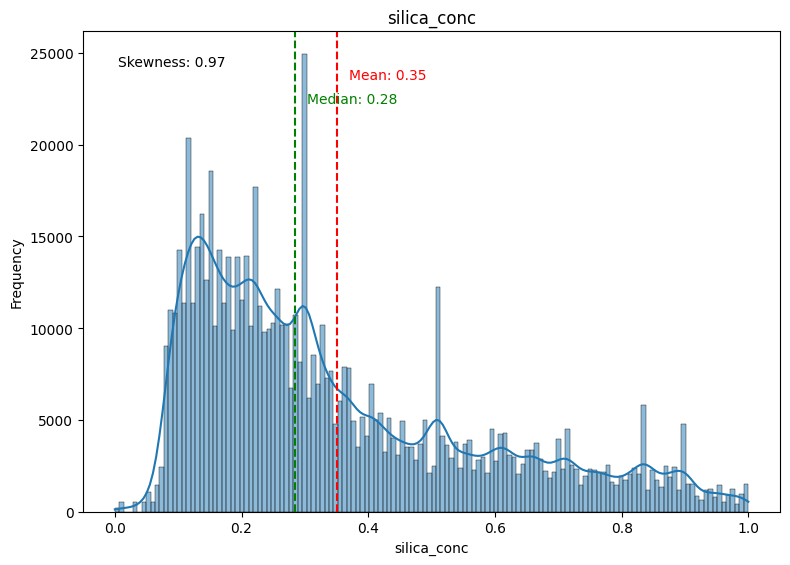

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew

fig, ax = plt.subplots(figsize=(8, 6))

data = flotation['silica_conc']
skewness = skew(data)

sns.histplot(data, kde=True, ax=ax)
ax.axvline(data.mean(), color='r', linestyle='--')
ax.axvline(data.median(), color='g', linestyle='--')

ax.text(data.mean() + 0.02 * (data.max() - data.min()), 0.9 * ax.get_ylim()[1], f'Mean: {data.mean():.2f}', color='r')
ax.text(data.median() + 0.02 * (data.max() - data.min()), 0.85 * ax.get_ylim()[1], f'Median: {data.median():.2f}', color='g')

ax.text(0.05, 0.95, f'Skewness: {skewness:.2f}', transform=ax.transAxes, ha='left', va='top')
ax.set_title('silica_conc')
ax.set_xlabel('silica_conc')
ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the top spacing here
plt.show()



- Skewness of the target variable ```silica_conc``` is 0.97 (right skewed)

- We will check skewness of independent variables

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew

variables = ['silica_feed', 'starch_flow', 'amina_flow', 'pulp_flow', 'pulp_pH',
             'pulp_density', 'airflow_col', 'level_col',]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 10))

plt.subplots_adjust(hspace=0.4, wspace=0.3)
for i, variable in enumerate(variables):
    row = i // 2
    col = i % 2

    data = flotation[variable]
    skewness = skew(data)

    sns.histplot(data, kde=True, ax=axes[row, col])
    axes[row, col].axvline(data.mean(), color='r', linestyle='--', label='Mean')
    axes[row, col].axvline(data.median(), color='g', linestyle='--', label='Median')
    axes[row, col].text(0.05, 0.95, f'Skewness: {skewness:.2f}', transform=axes[row, col].transAxes, ha='left', va='top')
    axes[row, col].set_title(variable)
    axes[row, col].set_xlabel(variable)
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew

variables = ['silica_feed', 'starch_flow', 'amina_flow', 'pulp_flow', 'pulp_pH',
             'pulp_density', 'airflow_col', 'level_col']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 12), sharex=True)

plt.subplots_adjust(hspace=0.4, wspace=0.3)

for i, variable in enumerate(variables):
    row = i // 2
    col = i % 2

    data = flotation[variable]
    skewness = skew(data)

    sns.histplot(data, kde=True, ax=axes[row, col])
    axes[row, col].axvline(data.mean(), color='r', linestyle='--', label='Mean')
    axes[row, col].axvline(data.median(), color='g', linestyle='--', label='Median')

    axes[row, col].text(data.mean() + 0.02 * (data.max() - data.min()), 0.9 * axes[row, col].get_ylim()[1], f'Mean: {data.mean():.2f}', color='r')
    axes[row, col].text(data.median() + 0.02 * (data.max() - data.min()), 0.85 * axes[row, col].get_ylim()[1], f'Median: {data.median():.2f}', color='g')

    axes[row, col].text(0.05, 0.95, f'Skewness: {skewness:.2f}', transform=axes[row, col].transAxes, ha='left', va='top')
    axes[row, col].set_title(variable)
    axes[row, col].set_xlabel(variable)
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()  # Adjust the top spacing here
plt.show()


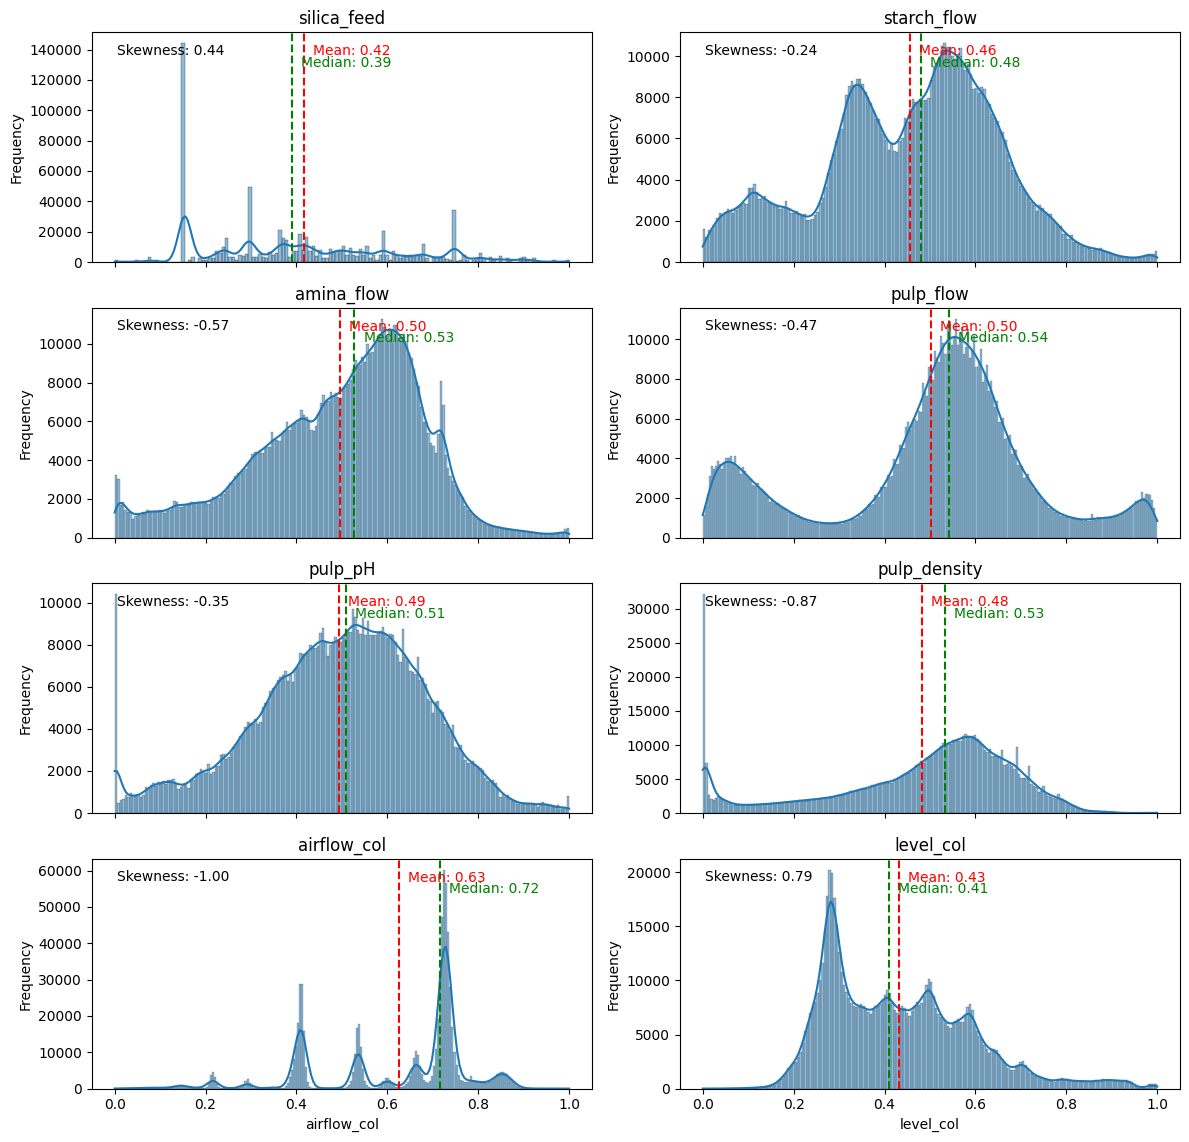

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew

variables = ['silica_feed', 'starch_flow', 'amina_flow', 'pulp_flow', 'pulp_pH',
             'pulp_density', 'airflow_col', 'level_col']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 12), sharex=True)

plt.subplots_adjust(hspace=0.4, wspace=0.3)

for i, variable in enumerate(variables):
    row = i // 2
    col = i % 2

    data = flotation[variable]
    skewness = skew(data)

    sns.histplot(data, kde=True, ax=axes[row, col])
    axes[row, col].axvline(data.mean(), color='r', linestyle='--')
    axes[row, col].axvline(data.median(), color='g', linestyle='--')

    axes[row, col].text(data.mean() + 0.02 * (data.max() - data.min()), 0.9 * axes[row, col].get_ylim()[1], f'Mean: {data.mean():.2f}', color='r')
    axes[row, col].text(data.median() + 0.02 * (data.max() - data.min()), 0.85 * axes[row, col].get_ylim()[1], f'Median: {data.median():.2f}', color='g')

    axes[row, col].text(0.05, 0.95, f'Skewness: {skewness:.2f}', transform=axes[row, col].transAxes, ha='left', va='top')
    axes[row, col].set_title(variable)
    axes[row, col].set_xlabel(variable)
    axes[row, col].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the top spacing here
plt.show()


We will use boxcox transformation method for target variable adjust

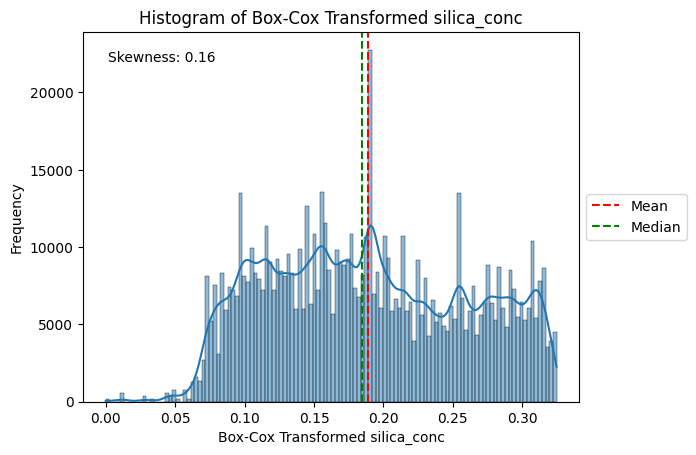

In [108]:
from scipy.stats import boxcox
import numpy as np

# Add a constant value to shift the data
shifted_data = flotation['silica_conc'] + abs(min(flotation['silica_conc'])) + 1

# Apply Box-Cox transformation
transformed, lambda_value = boxcox(shifted_data)

# Calculate the skewness of the transformed data
transformed_skewness = skew(transformed)

# Create the histogram of the transformed data
sns.histplot(transformed, kde=True)
plt.axvline(np.mean(transformed), color='r', linestyle='--', label='Mean')
plt.axvline(np.median(transformed), color='g', linestyle='--', label='Median')
plt.text(0.05, 0.95, f'Skewness: {transformed_skewness:.2f}',
         transform=plt.gca().transAxes, ha='left', va='top')

# Set plot title and labels
plt.title('Histogram of Box-Cox Transformed silica_conc')
plt.xlabel('Box-Cox Transformed silica_conc')
plt.ylabel('Frequency')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [ ]:
from scipy.stats import zscore
zscores = zscore(flotation["silica_conc"])
for i in range(1,5):
    print("The score threshold is: {}".format(i))
    print("The indices of the outliers:")
    print(np.where(zscores > i))
    print("Number of outliers is: {}".format(len((np.where(zscores > i)[0]))))
    print('--'*40)


The score threshold is: 1
The indices of the outliers:
(array([  3054,   3055,   3056, ..., 732139, 732140, 732141]),)
Number of outliers is: 134214
--------------------------------------------------------------------------------
The score threshold is: 2
The indices of the outliers:
(array([  5214,   5215,   5216, ..., 715457, 715458, 715459]),)
Number of outliers is: 46775
--------------------------------------------------------------------------------
The score threshold is: 3
The indices of the outliers:
(array([], dtype=int64),)
Number of outliers is: 0
--------------------------------------------------------------------------------
The score threshold is: 4
The indices of the outliers:
(array([], dtype=int64),)
Number of outliers is: 0
--------------------------------------------------------------------------------


In [ ]:
flotation.columns


Index(['silica_feed', 'starch_flow', 'amina_flow', 'pulp_flow', 'pulp_pH',
       'pulp_density', 'airflow_col1', 'airflow_col4', 'airflow_col5',
       'airflow_col6', 'level_col1', 'level_col2', 'level_col3', 'level_col4',
       'level_col5', 'level_col6', 'silica_conc'],
      dtype='object')

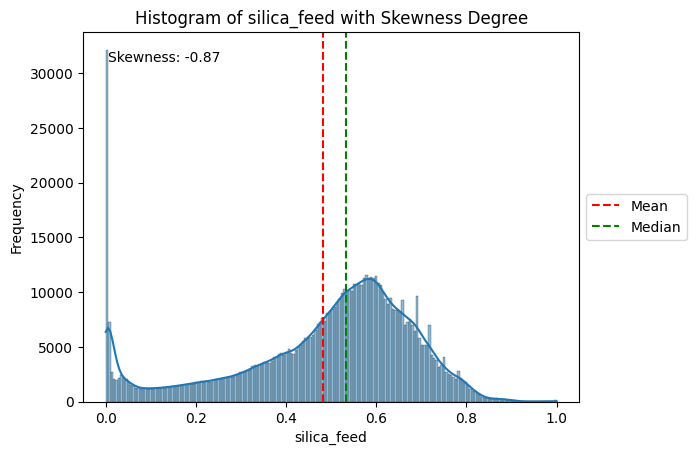

In [ ]:
# Assuming 'flotation' is the DataFrame and 'silica_conc' is the column of interest
data = flotation['pulp_density']

# Calculate the skewness degree
skewness = skew(data)

# Create the histogram with skewness degree
sns.histplot(data, kde=True)
plt.axvline(data.mean(), color='r', linestyle='--', label='Mean')
plt.axvline(data.median(), color='g', linestyle='--', label='Median')

# Add skewness degree as text in upper left corner
plt.text(0.05, 0.95, f'Skewness: {skewness:.2f}', transform=plt.gca().transAxes, ha='left', va='top')

# Set plot title and labels
plt.title('Histogram of silica_feed with Skewness Degree')
plt.xlabel('silica_feed')
plt.ylabel('Frequency')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


##**5. Modelling**

##**6. Evaluating**

##**7. Tunning Model**